# Статистический анализ данных пользователей сервиса GoFast

**Цель проекта**

Цель проекта - анализ данных о пользователях, их поездках и подписках в сервисе проката самокатов GoFast и проверка гипотез:
* Тратят ли пользователи с подпиской больше времени на поездку?
* Можно ли сказать что расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров?
* Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Описание входных данных**

Таблица с данными о пользователях — `users_go.csv`
- `user_id` —	уникальный идентификатор пользователя
- `name` — имя пользователя
- `age` — возраст пользователя
- `city` —	город
- `subscription_type` — тип подписки (free, ultra)

Таблица с данными о поездках пользователей — `rides_go.csv`
- `user_id` — уникальный идентификатор пользователя
- `distance` — расстояние, которое пользователь проехал за поездку (в метрах)
- `duration` — продолжительность поездки (в минутах)
- `date` — дата совершения поездки

Таблица с информацией о подписках — `subscriptions_go.csv`
- `subscription_type` —	тип подписки (free, ultra)
- `minute_price` — стоимость одной минуты поездки по данной подписке
- `start_ride_price` — стоимость начала поездки
- `subscription_fee` — стоимость ежемесячного платежа

## Загрузка данных

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial

### Сохранение датафреймов

In [2]:
try:
    users_go = pd.read_csv('users_go.csv')
except:
    users_go = pd.read_csv('/datasets/users_go.csv')

In [3]:
try:
    rides_go = pd.read_csv('rides_go.csv')
except:
    rides_go = pd.read_csv('/datasets/rides_go.csv')

In [4]:
try:
    subscriptions_go = pd.read_csv('subscriptions_go.csv')
except:
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

### Изучение общей информации о датафреймах

In [5]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [9]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


### Вывод

Открыли 3 датасета: users_go, rides_go, subscriptions_go.

Необходимо провести предобработку данных, чтобы изменить тип данных в столбце с датой, добавить новый столбец с номером месяца, а так же обработать возможные дубликаты в данных.

## Предобработка данных

### Работа с типами данных

In [11]:
rides_go.date = pd.to_datetime(rides_go.date, format='%Y-%m-%d')
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Добавление нового столбца с номером месяца

In [12]:
rides_go['month'] = pd.DatetimeIndex(rides_go.date).month
rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [13]:
f'В проекте присутсвуют данные в период с {rides_go.date.min()} по {rides_go.date.max()}'

'В проекте присутсвуют данные в период с 2021-01-01 00:00:00 по 2021-12-30 00:00:00'

В проекте присутствуют данные за один календарный год, так что мы получим достоверную статистику по месяцам в выборке.

### Обработка дубликатов

In [14]:
users_go.duplicated().sum()

31

In [15]:
users_go = users_go.drop_duplicates().reset_index(drop=True)
users_go.duplicated().sum()

0

### Вывод

В результате предобработки данных:
* был изменен тип данных в столбце с датой для возможности дальнейших рассчетов
* добавлен новый столбец с номером месяца
* обработаны дубликаты

## Исследовательский анализ данных

### Частота встречаемости городов;

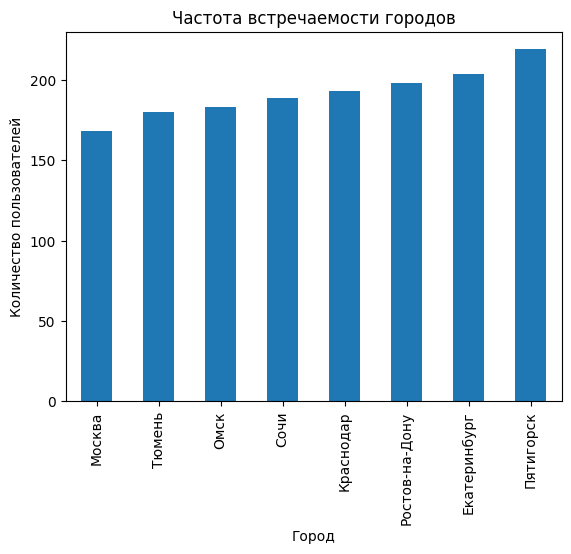

In [16]:
(users_go.pivot_table(index='city', values='user_id',
                      aggfunc='count').sort_values(by='user_id').plot(
                          kind='bar',
                          title='Частота встречаемости городов',
                          ylabel='Количество пользователей',
                          xlabel='Город',
                          legend=None))
plt.show()

### Соотношение пользователей с подпиской и без подписки;

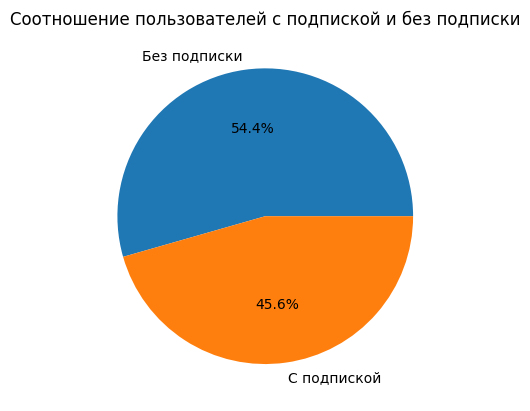

In [17]:
(users_go.pivot_table(
    index='subscription_type', values='user_id', aggfunc='count').plot(
        y='user_id',
        kind='pie',
        labels=['Без подписки', 'С подпиской'],
        autopct='%1.1f%%',
        title='Соотношение пользователей с подпиской и без подписки',
        ylabel='',
        legend=None))
plt.show()

### Возраст пользователей;

In [18]:
users_go.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

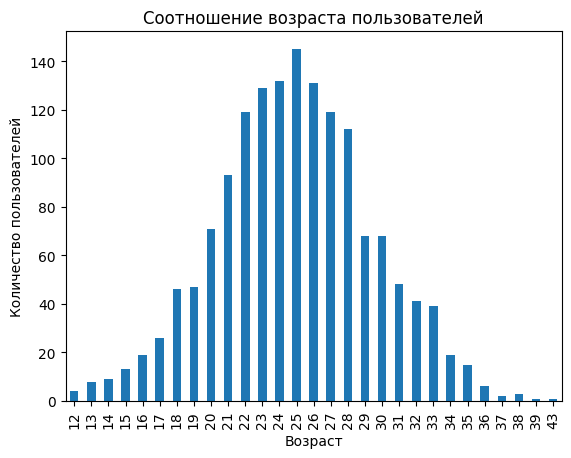

In [19]:
(users_go.pivot_table(index='age', values='user_id', aggfunc='count').plot(
    kind='bar',
    title='Соотношение возраста пользователей',
    xlabel='Возраст',
    ylabel='Количество пользователей',
    legend=None))
plt.show()

### Расстояние, которое пользователь преодолел за одну поездку;

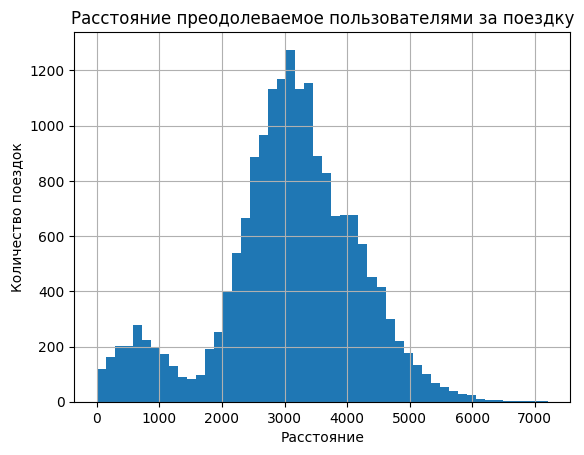

In [20]:
ax = (rides_go.distance.plot(
    kind='hist',
    bins=50,
    grid=True,
    title='Расстояние преодолеваемое пользователями за поездку'))
ax.set_xlabel('Расстояние')
ax.set_ylabel('Количество поездок')
plt.show()

### Продолжительность поездок.

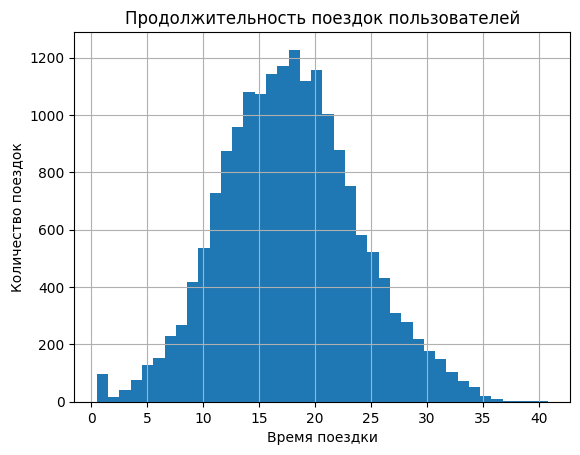

In [21]:
ax = (rides_go.duration.plot(kind='hist',
                             bins=40,
                             grid=True,
                             title='Продолжительность поездок пользователей'))
ax.set_xlabel('Время поездки')
ax.set_ylabel('Количество поездок')
plt.show()

### Вывод

* В выборке присутствуют данные о пользователях из 8 городов России. В среднем примерно по 190 пользователей из каждого города.
* Пользователей с платной подпиской в выборке меньше, чем без нее на 136. 835 пользователей без подписки и 699 с подпиской.
* Возраст пользователей в выборке нормально распределен вокруг среднего в 25лет.
* Если не учитывать пик коротких поездок, расстояние поездок распределено нормально вокруг среднего в 3100 метров.
* Продолжительность поездок в выборке распределено нормально вокруг среднего в 17,5 минут.

## Объединение данных

### Объединение данные о пользователях, поездках и подписках в один датафрейм. 

In [22]:
data = users_go.merge(rides_go, on='user_id')
data.sample(15)

,user_id,name,age,city,subscription_type,distance,duration,date,month
12807,1161,Александр,26,Тюмень,free,4203.761308,22.700988,2021-08-14,8
11844,1090,Дмитрий,22,Ростов-на-Дону,free,4180.745387,10.649818,2021-02-18,2
11349,1055,Дарья,27,Пятигорск,free,3743.420489,16.037827,2021-01-11,1
2779,296,Платон,19,Екатеринбург,ultra,2427.467288,25.240731,2021-10-01,10
714,78,Ростислав,21,Пятигорск,ultra,3698.242053,30.491210,2021-04-12,4
12328,1126,Владислав,26,Ростов-на-Дону,free,2783.852349,13.186339,2021-08-30,8
4807,517,Олег,25,Краснодар,ultra,1752.479471,15.007084,2021-12-24,12
16340,1413,Константин,33,Екатеринбург,free,2687.445581,13.560232,2021-02-11,2
10385,984,Анжелика,34,Краснодар,free,4940.558010,34.948498,2021-08-01,8
11129,1038,Ярослав,18,Пятигорск,free,2305.390252,8.769773,2021-01-11,1


In [23]:
data = data.merge(subscriptions_go, on='subscription_type')
data.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
8714,866,Дарина,34,Москва,free,4894.590002,21.747016,2021-05-09,5,8,50,0
4360,468,Снежана,31,Краснодар,ultra,2612.422411,15.598048,2021-12-03,12,6,0,199
9247,904,Данила,30,Пятигорск,free,2594.213785,26.150257,2021-05-05,5,8,50,0
12358,1128,Георгий,27,Краснодар,free,2767.345266,19.149656,2021-11-22,11,8,50,0
7850,797,Николай,28,Пятигорск,free,3414.505819,13.782650,2021-11-20,11,8,50,0
16455,1420,Юлия,18,Краснодар,free,2288.435725,15.734695,2021-10-29,10,8,50,0
14029,1247,Марат,30,Омск,free,4582.109867,17.746330,2021-03-26,3,8,50,0
3513,378,Кирилл,24,Москва,ultra,597.443992,5.991480,2021-01-03,1,6,0,199
1465,159,Нелли,25,Тюмень,ultra,1285.260577,17.141042,2021-07-22,7,6,0,199
7397,763,Захар,20,Краснодар,free,5538.342991,31.561583,2021-02-26,2,8,50,0


In [24]:
if data.shape[0] == rides_go.shape[0]:
    print('Все данные попали в новый датафрейм')
else:
    print('В результате объединения данные были потеряны')

Все данные попали в новый датафрейм


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


### Создание дополнительных датафреймов с данными о пользователях с подпиской и без

In [26]:
data_free = data.query('subscription_type == "free"')
data_free.sample(15)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
10865,1019,Диана,25,Краснодар,free,216.259429,2.480577,2021-07-26,7,8,50,0
15733,1372,Святослав,28,Краснодар,free,992.778336,13.985557,2021-03-14,3,8,50,0
6523,701,Иван,31,Екатеринбург,free,2465.852577,14.283970,2021-05-31,5,8,50,0
17731,1511,Элина,27,Краснодар,free,3152.663856,21.566393,2021-08-02,8,8,50,0
12856,1164,Алёна,25,Омск,free,2496.649250,10.809043,2021-10-23,10,8,50,0
13554,1214,Савелий,25,Ростов-на-Дону,free,1046.654366,10.488848,2021-04-07,4,8,50,0
8795,871,Михаил,21,Екатеринбург,free,3746.705278,23.986821,2021-10-25,10,8,50,0
13008,1176,Владислав,30,Екатеринбург,free,3860.261078,20.029317,2021-03-11,3,8,50,0
13100,1182,Одиссей,26,Тюмень,free,1601.207055,11.404828,2021-12-15,12,8,50,0
16251,1406,Вероника,28,Ростов-на-Дону,free,3916.558156,25.368078,2021-12-30,12,8,50,0


In [27]:
data_ultra = data.query('subscription_type == "ultra"')
data_ultra.sample(15)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
4851,523,Ян,23,Тюмень,ultra,3251.640903,17.838803,2021-05-10,5,6,0,199
6405,688,Мирослава,26,Москва,ultra,4004.404223,23.348014,2021-12-04,12,6,0,199
5991,641,Артём,27,Краснодар,ultra,3135.474830,10.718875,2021-12-04,12,6,0,199
1924,208,Вадим,23,Пятигорск,ultra,4030.254499,13.338458,2021-09-01,9,6,0,199
555,61,Федор,32,Москва,ultra,3161.843766,27.971063,2021-05-29,5,6,0,199
194,20,Игорь,23,Омск,ultra,2871.785874,17.487143,2021-07-25,7,6,0,199
2461,262,Яна,27,Сочи,ultra,3320.789866,10.115978,2021-02-06,2,6,0,199
5599,597,Даниэль,30,Ростов-на-Дону,ultra,2472.296510,10.115096,2021-05-06,5,6,0,199
2704,288,Евгений,24,Екатеринбург,ultra,3223.545341,18.179617,2021-09-24,9,6,0,199
6274,672,Демид,28,Екатеринбург,ultra,4514.246648,27.056987,2021-03-25,3,6,0,199


### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

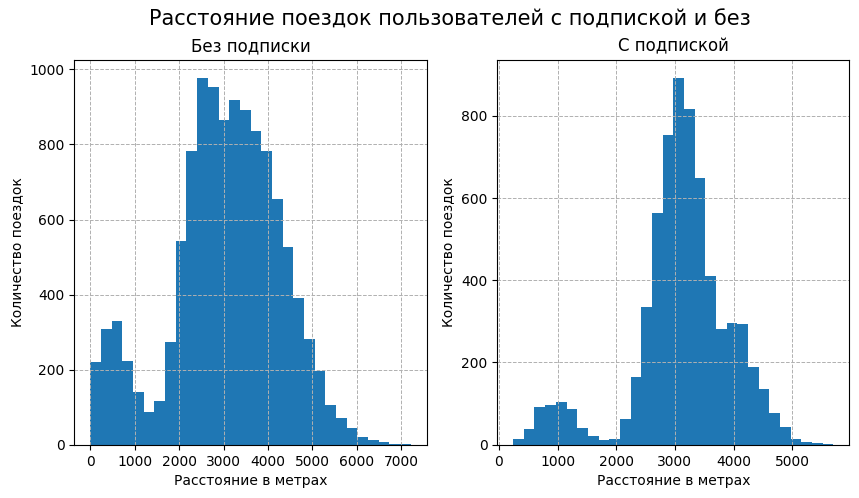

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Расстояние поездок пользователей с подпиской и без', fontsize=15)
ax[0].hist(data_free.distance, bins=30)
ax[0].set_title('Без подписки')
ax[0].set_xlabel('Расстояние в метрах')
ax[0].set_ylabel('Количество поездок')
ax[0].grid(linestyle='--', linewidth=0.7)
ax[1].hist(data_ultra.distance, bins=30)
ax[1].set_title('С подпиской')
ax[1].set_xlabel('Расстояние в метрах')
ax[1].set_ylabel('Количество поездок')
ax[1].grid(linestyle='--', linewidth=0.7)
plt.show()

#### Вывод
Графики расстояния поездок пользователей без платной подписки и с подпиской имеют схожее распределение, близкое к нормальному. Они имеют схожий пик количества поездок около 3000 метров.

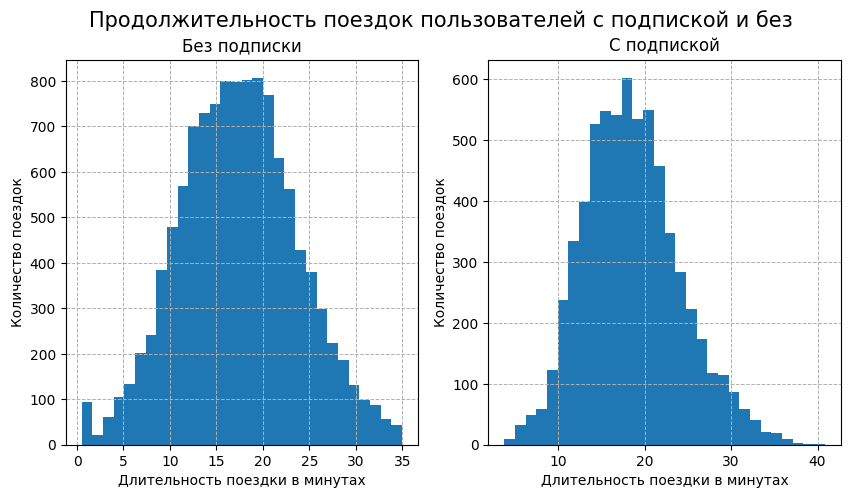

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Продолжительность поездок пользователей с подпиской и без',
             fontsize=15)
ax[0].hist(data_free.duration, bins=30)
ax[0].set_title('Без подписки')
ax[0].set_xlabel('Длительность поездки в минутах')
ax[0].set_ylabel('Количество поездок')
ax[0].grid(linestyle='--', linewidth=0.7)
ax[1].hist(data_ultra.duration, bins=30)
ax[1].set_title('С подпиской')
ax[1].set_xlabel('Длительность поездки в минутах')
ax[1].set_ylabel('Количество поездок')
ax[1].grid(linestyle='--', linewidth=0.7)
plt.show()

#### Вывод
Графики продолжительности поездок пользователей без платной подписки и с подпиской имеют схожее распределение, близкое к нормальному. Они имеют схожий пик количества поездок около 17 метров.

### Вывод

* Создал датафрейм data с объединенными данными о пользователях, поездках и подписках.
* Создал два дополнительных датафрейма data_ultra и data_free с данными о пользователях с подпиской и без
* Построил графики для визуализации информации о расстоянии и времени поездок для пользователей обеих категорий

## Подсчёт выручки

### Создание датафрейма с данными о суммарном расстоянии, количестве поездок и суммарном времени для каждого пользователя за каждый месяц

In [30]:
data['duration'] = np.ceil(data['duration']) 
data_agg = data.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc=['sum', 'count'])
data_agg.columns = ['sum_distance', 'sum_duration', 'count', 'drop']
data_agg.drop(columns='drop', inplace=True)
data_agg = data_agg.reset_index()
data_agg.head(15)

,user_id,month,sum_distance,sum_duration,count
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3
5,1,12,6751.629942,28.0,2
6,2,3,10187.723006,63.0,3
7,2,4,6164.381824,40.0,2
8,2,6,3255.338202,14.0,1
9,2,7,6780.722964,48.0,2


### Добавление столбца с суммарной выручкой от каждого пользователя за каждый месяц

In [31]:
data_agg = data_agg.merge(users_go[['user_id', 'subscription_type']], on='user_id')
data_agg.sample(15)

,user_id,month,sum_distance,sum_duration,count,subscription_type
4443,684,12,3531.683822,25.0,1,ultra
2632,404,1,4052.521458,21.0,1,ultra
11219,1522,9,217.943366,15.0,1,free
7185,1029,10,1144.673184,22.0,2,free
8485,1190,2,3654.275943,22.0,1,free
5914,875,11,4019.423129,21.0,1,free
9249,1279,7,3817.610723,16.0,1,free
6168,907,2,1549.918779,17.0,1,free
5493,822,5,4277.877875,21.0,1,free
2181,335,4,6678.912676,43.0,2,ultra


In [32]:
def get_month_gain(row):
    if row['subscription_type'] == 'free':
        month_gain = (row['count'] * subscriptions_go.start_ride_price[0] +
                      row['sum_duration'] * subscriptions_go.minute_price[0] +
                      subscriptions_go.subscription_fee[0])
        return month_gain
    if row['subscription_type'] == 'ultra':
        month_gain = (row['count'] * subscriptions_go.start_ride_price[1] +
                      row['sum_duration'] * subscriptions_go.minute_price[1] +
                      subscriptions_go.subscription_fee[1])
        return month_gain

In [33]:
data_agg['month_gain'] = data_agg.apply(get_month_gain, axis=1)
data_agg.head(15)

,user_id,month,sum_distance,sum_duration,count,subscription_type,month_gain
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,46.0,2,ultra,475.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,56.0,3,ultra,535.0
5,1,12,6751.629942,28.0,2,ultra,367.0
6,2,3,10187.723006,63.0,3,ultra,577.0
7,2,4,6164.381824,40.0,2,ultra,439.0
8,2,6,3255.338202,14.0,1,ultra,283.0
9,2,7,6780.722964,48.0,2,ultra,487.0


### Вывод

* Создал датафрейм data_agg c данными о суммарном расстоянии, количестве поездок и суммарном времени для каждого пользователя за каждый месяц
* Добавил в data_agg столбец с месячной выручкой от каждого пользователя за каждый месяц

## Проверка гипотез

### Тратят ли пользователи с подпиской больше времени на поездки? 

Нулевая гипотеза: средняя длительность поездок пользователей с подпиской и без - равны, альтернативная гипотеза: средняя длительность поездок пользователей с подпиской больше, чем у пользователей без подписки.

In [34]:
duration_free = data_free['duration']
duration_ultra = data_ultra['duration']
alpha = .05
results = st.ttest_ind(duration_ultra, duration_free, equal_var=False, alternative='greater')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 5.675781377128977e-37
Отвергаем нулевую гипотезу


Нулевая гипотеза в результате теста была отвергнута в пользу альтернативной, а значит, что для имеющихся выборок - пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.

### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской равно 3130 метров, альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской меньше 3130 метров.

In [35]:
interested_value = 3130
alpha = 0.05
distance_ultra = data_ultra['distance']
results = st.ttest_1samp(distance_ultra, interested_value, alternative = 'less')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.08046311521502145
Нет оснований отвергнуть нулевую гипотезу


Нулевая гипотеза не была отвергнута в результате теста. Для имеющейся выборки нет оснований полагать, что пользователи с подпиской проезжают меньше 3130 метров.

### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза: средняя помесячная выручка от пользователей с подпиской по месяцам равна средней выручке от пользователей без подписки, альтернативная гипотеза: средняя помесячная выручка от пользователей с подпиской по месяцам больше средней выручки от пользователей без подписки.

In [36]:
free_month_gain = data_agg.query('subscription_type == "free"')['month_gain']
ultra_month_gain = data_agg.query('subscription_type == "ultra"')['month_gain']
alpha = 0.05
results = st.ttest_ind(ultra_month_gain, free_month_gain, equal_var=False, alternative = 'greater')
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Нулевая гипотеза в результате теста была отвергнута в пользу альтернативной. Для имеющихся выборок - средняя помесячная выручка от пользователей с подпиской по месяцам больше средней выручки от пользователей без подписки.

###  Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки гипотезы что количество обращений в техподдержку значимо снизилось после обновления серверов понадобился бы scipy.stats.ttest_rel(), который подходит для зависимых (парных) выборок.

### Вывод

* Пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.
* Для имеющейся выборки нет оснований полагать, что пользователи с подпиской проезжают меньше 3130 метров.
* Средняя помесячная выручка от пользователей с подпиской по месяцам больше средней выручки от пользователей без подписки.
* Для проверки гипотезы что количество обращений в техподдержку значимо снизилось после обновления серверов понадобился бы scipy.stats.ttest_rel(), который подходит для зависимых (парных) выборок.

## Распределения

### Акция с промокодами
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Для решения задачи используем биноминальное распределение. Найдем подходящее количество экспериментов, чтобы вероятность получить меньше 100 клиентов была меньше 5%.

In [37]:
n = 100 
p = 0.1 
result = 1
while result > 0.05:
    distr = st.binom(n, p)
    result = distr.cdf(100)
    n += 1
print(result)
n

0.04954795210203071


1173

Минимальное количество промокодов, которые нужно разослать - 1173.

C:\ProgramData\Anaconda3\envs\practicum\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


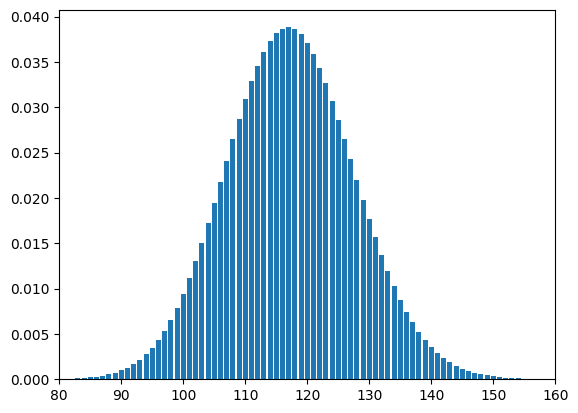

In [38]:
n = 1173
p = 0.1
distr = []
for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
plt.bar(range(0, n + 1), distr)
plt.xlim(80,160)
plt.show()

#### Вывод

Чтобы по итогам акции выполнить план в 100 клиентов продливших подписку - необходимо отправить как минимум 1173 промокода.

### Задача от отдела маркетинга
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

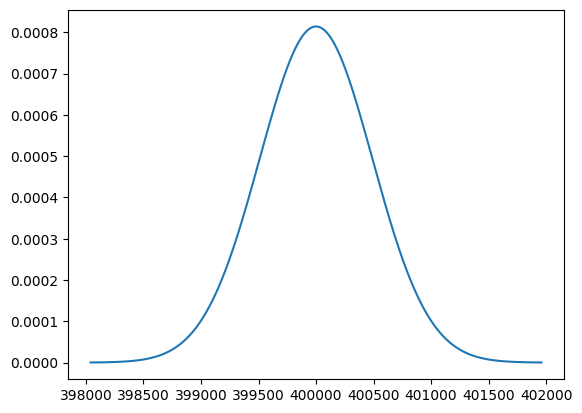

In [39]:
# задаем параметры биноминального определения
n = 1000000 
p = 0.4

# задаем параметры нормального определения для аппроксимации нашего биноминального распределения
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# задаем нормальное распределение
distr = st.norm(mu, sigma)

# зададим границы промежутка, в котором будем строить аппроксимацию
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)
 
# получим список из 1000 чисел от left до right
x = np.linspace(left, right, 1000)

# рисуем график биномиального распределения
plt.plot(x, distr.pdf(x))
plt.show()

С помощью аппроксимации получили примерный график распределения. Найдем вероятность того, что уведомление откроют не более 399500 пользователей.

In [40]:
# находим требуемую вероятность
result = distr.cdf(399500)
result

0.15371708296369768

#### Вывод

Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей примерно равна 15,4%.

## Общий вывод

Для исследования было использовано 3 исходных датасета: users_go, rides_go и subscriptions_go.

В результате предобработки данных был изменен тип данных в столбце с датой для возможности дальнейших рассчетов, добавлен новый столбец с номером месяца, обработаны дубликаты.

Был произведен исследовательский анализ данных датасетов.

Было создано 3 дополнительных датафрейма: data - с объединенными данными о пользователях, поездках и подписках, data_ultra - с данными о пользователях с платной подпиской и data_free с данными о пользователях без подписки.

Также, был создан датафрейм data_agg c данными о суммарном расстоянии, количестве поездок, суммарном времени и месячной выручкой для каждого пользователя за каждый месяц.

В результате проверки гипотез получили следующие выводы:
* Пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.
* Для имеющейся выборки нет оснований полагать, что пользователи с подпиской проезжают меньше 3130 метров.
* Средняя помесячная выручка от пользователей с подпиской больше средней помесячной выручки от пользователей без подписки.

Были проведены рассчеты для отдела маркетинга, в результате которых было выяснено:
* Чтобы по итогам акции с промокодами выполнить план в 100 клиентов продливших подписку - необходимо отправить как минимум 1173 промокода.
* Вероятность того, что push-уведомление откроют не более 399,5 тысяч пользователей примерно равна 15,4%.